In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt 

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency


%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gb-credit-default/sample_submission.csv
/kaggle/input/gb-credit-default/train.csv
/kaggle/input/gb-credit-default/test.csv


In [27]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [28]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [29]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [30]:
# input 
DATASET_PATH = '/kaggle/input/gb-credit-default/train.csv'

SAMPLE_SUBM_PATH = '/kaggle/input/gb-credit-default/sample_submission.csv'

TEST_DATASET_PATH = '/kaggle/input/gb-credit-default/test.csv'



In [31]:
sample_submission = pd.read_csv(SAMPLE_SUBM_PATH)
sample_submission.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


## EDA

In [32]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [33]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [34]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [35]:
df.shape

(7500, 17)

In [36]:
df.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [38]:
# Анализ целевой переменной
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Целевая переменная не сбалансирована

## Обзор количественных признаков

In [39]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [40]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*'*100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [41]:
features_num = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History','Maximum Open Credit', 'Months since last delinquent','Number of Credit Problems','Bankruptcies', 'Current Loan Amount', 'Current Credit Balance','Monthly Debt','Credit Score']

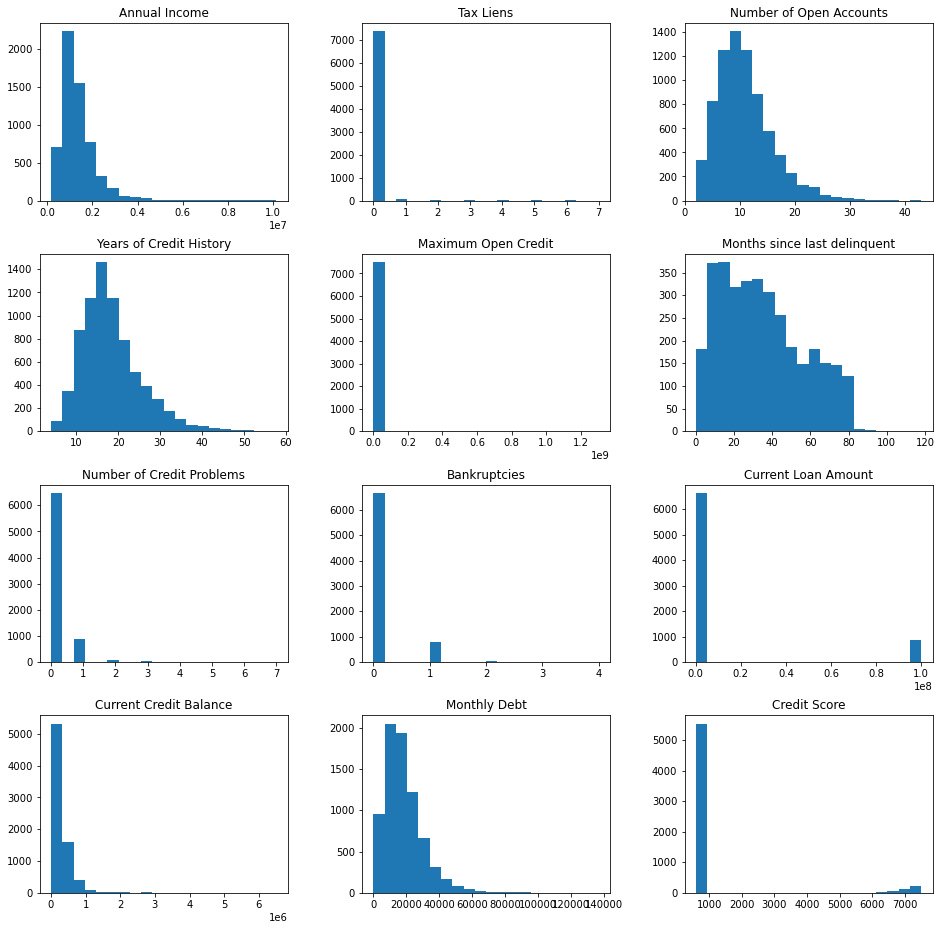

In [42]:
df[features_num].hist(figsize=(16, 16), bins=20, grid=False);

## Обработка выбросов

In [43]:
# Убираем лишние 0 в Credit Score  в train
for cr_score in df['Credit Score']:
    if (len(str(cr_score))) > 5:
        # print(cr_score)
        df.loc[df['Credit Score'] == cr_score, 'Credit Score'] = cr_score/10

In [44]:
# Убираем лишние 0 в Credit Score в test
for cr_score in df_test['Credit Score']:
    if (len(str(cr_score))) > 5:
        # print(cr_score)
        df_test.loc[df_test['Credit Score'] == cr_score, 'Credit Score'] = cr_score/10

In [45]:
df.nlargest(10, 'Maximum Open Credit')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,99999999.0,1908550.0,5770.0,743.0,0
7026,Home Mortgage,3312365.0,5 years,0.0,13.0,25.3,2.640700e+07,0.0,50.0,0.0,home improvements,Long Term,99999999.0,2440246.0,39196.0,745.0,0
4769,Home Mortgage,3739960.0,9 years,0.0,7.0,22.8,2.634333e+07,0.0,NaN,0.0,home improvements,Short Term,757834.0,6506797.0,38023.0,703.0,0
5523,Home Mortgage,1520304.0,10+ years,0.0,21.0,35.5,2.137243e+07,0.0,0.0,0.0,other,Long Term,99999999.0,1975012.0,12555.0,728.0,0
5731,Home Mortgage,1475198.0,8 years,0.0,10.0,24.9,1.928043e+07,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,1132286.0,17543.0,751.0,0
3170,Home Mortgage,2226230.0,10+ years,0.0,20.0,19.0,1.868381e+07,0.0,NaN,0.0,buy a car,Short Term,111892.0,2355867.0,17123.0,750.0,0


In [46]:
df = df[df['Maximum Open Credit']<99999999]
df_test = df_test[df_test['Maximum Open Credit']<99999999]

In [47]:
# Number of Open Accounts
df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    561
6.0     504
13.0    464
14.0    420
5.0     325
15.0    313
16.0    265
17.0    231
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      2
37.0      2
42.0      1
43.0      1
35.0      1
38.0      1
41.0      1
Name: Number of Open Accounts, dtype: int64

In [48]:
df['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
358732.0      3
323312.0      3
             ..
1435456.0     1
397078.0      1
537680.0      1
704132.0      1
469216.0      1
Name: Maximum Open Credit, Length: 6960, dtype: int64

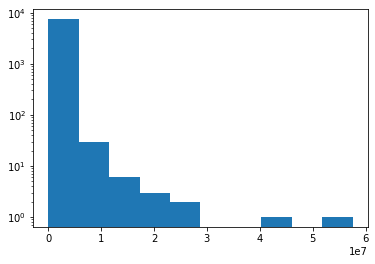

In [49]:
plt.hist(df['Maximum Open Credit'],bins=10)
plt.yscale(value="log")
plt.show()

In [50]:
df['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
265826.0        5
216106.0        5
             ... 
201080.0        1
427812.0        1
665544.0        1
108350.0        1
191136.0        1
Name: Current Loan Amount, Length: 5383, dtype: int64

In [51]:
median_loan_by_purpose = df.groupby('Purpose', as_index=False).agg({'Current Loan Amount':'median'})
median_loan_by_purpose_test = df_test.groupby('Purpose', as_index=False).agg({'Current Loan Amount':'median'})

In [52]:
for purpose in median_loan_by_purpose['Purpose']:
    df.loc[(df['Current Loan Amount']==99999999) & (df['Purpose']==str(purpose)), 'Current Loan Amount'] = median_loan_by_purpose.loc[median_loan_by_purpose['Purpose']==purpose, 'Current Loan Amount']

for purpose in median_loan_by_purpose_test['Purpose']:
    df_test.loc[(df_test['Current Loan Amount']==99999999) & (df_test['Purpose']==str(purpose)), 'Current Loan Amount'] = median_loan_by_purpose_test.loc[median_loan_by_purpose_test['Purpose']==purpose, 'Current Loan Amount']

## Обработка пропусков

In [53]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1556
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4079
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount              870
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1556
Credit Default                     0
dtype: int64

In [54]:
df['Annual Income'].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
2326075.0    1
330429.0     1
1704965.0    1
727852.0     1
648166.0     1
Name: Annual Income, Length: 5477, dtype: int64

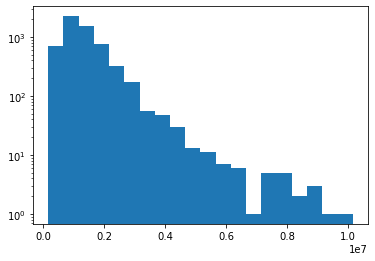

In [55]:
plt.hist(df['Annual Income'],bins=20)
plt.yscale(value="log")
plt.show()

In [56]:
median_annual_income = df['Annual Income'].median()
df['Annual Income'] = df['Annual Income'].fillna(median_annual_income)

In [57]:
median_annual_income = df_test['Annual Income'].median()
df_test['Annual Income'] = df_test['Annual Income'].fillna(median_annual_income)

In [58]:
df['Credit Score'].value_counts()

740.0    184
747.0    172
748.0    163
745.0    155
741.0    155
        ... 
641.0      1
591.0      1
593.0      1
630.0      1
620.0      1
Name: Credit Score, Length: 160, dtype: int64

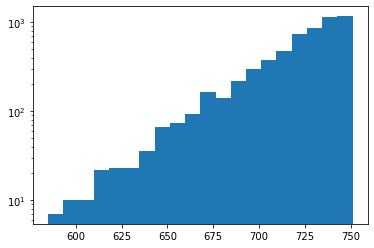

In [59]:
plt.hist(df['Credit Score'],bins=20)
plt.yscale(value="log")
plt.show()

In [60]:
median_cred_score = df['Credit Score'].median()
df['Credit Score'] = df['Credit Score'].fillna(median_cred_score)

In [61]:
median_cred_score = df_test['Credit Score'].median()
df_test['Credit Score'] = df_test['Credit Score'].fillna(median_cred_score)

In [62]:

df['Bankruptcies'].value_counts()

0.0    6657
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

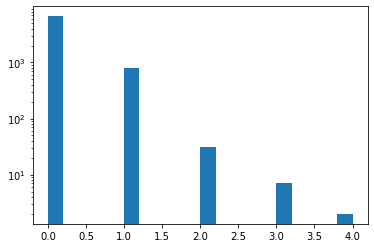

In [63]:
plt.hist(df['Bankruptcies'],bins=20)
plt.yscale(value="log")
plt.show()

In [64]:
df['Bankruptcies'] = df['Bankruptcies'].fillna(0)

In [65]:
df_test['Bankruptcies'] = df_test['Bankruptcies'].fillna(0)

In [66]:
df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mode()[0]

In [67]:
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = df_test['Years in current job'].mode()[0]

In [68]:
df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)

In [69]:
df_test['Months since last delinquent'] = df_test['Months since last delinquent'].fillna(0)

In [70]:
len(df) - df.count()

Home Ownership                    0
Annual Income                     0
Years in current job              0
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                      0
Purpose                           0
Term                              0
Current Loan Amount             870
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Credit Default                    0
dtype: int64

In [71]:
len(df_test) - df_test.count()

Home Ownership                    0
Annual Income                     0
Years in current job              0
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                      0
Purpose                           0
Term                              0
Current Loan Amount             297
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
dtype: int64

In [72]:
# Сохраним подготовленные данные
df_train_prep= df.copy()

In [73]:
df_train_prep

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,NaN,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,NaN,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,0.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,741.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,0.0,0.0,buy a car,Short Term,NaN,477812.0,12479.0,748.0,0
7498,Home Mortgage,1168272.0,10+ years,0.0,21.0,26.5,1141250.0,0.0,0.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,729.0,0


In [74]:
df_test_prep=df_test.copy()

In [75]:
df_test_prep.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,727.0
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,726.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,1178475.0,5 years,0.0,8.0,9.1,370524.0,0.0,0.0,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,727.0
9,Home Mortgage,2140445.0,10+ years,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


## Обучение модели

In [76]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [77]:
# Целевой признак
target = 'Credit Default'

In [78]:
# Все признаки 
features_all = df_train_prep.columns.drop('Credit Default').tolist()

In [79]:
# Num
features_without_categ =['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History','Maximum Open Credit', 'Number of Credit Problems','Bankruptcies', 'Current Loan Amount', 'Current Credit Balance','Monthly Debt','Credit Score']

In [80]:
features_categ=['Home Ownership','Years in current job','Purpose','Term']

## Приведение типов для модели CatBoost

In [81]:
for colname in features_categ:
    df_train_prep[colname] = pd.Categorical(df_train_prep[colname])
    
df_train_prep[features_categ].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

In [82]:
for colname in features_categ:
    df_test_prep[colname] = pd.Categorical(df_test_prep[colname])
    
df_test_prep[features_categ].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

In [105]:
# Создаем датафреймы из данных
X=pd.DataFrame(df_train_prep, columns=features_all)
X.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,NaN,47386.0,7914.0,749.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,NaN,308389.0,13651.0,742.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0


In [106]:
y = df_train_prep['Credit Default']

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True,stratify=df_train_prep['Credit Default'], random_state=2)
X_train.shape, X_test.shape

((5997, 16), (1500, 16))

In [108]:
y_train.value_counts()

0    4307
1    1690
Name: Credit Default, dtype: int64

## Балансировка целевой переменной

In [109]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [110]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()

0    4307
1    3380
Name: Credit Default, dtype: int64

In [111]:
X_train = df_balanced.drop(columns=target)
y_train = df_balanced[target]

In [90]:
# Catboost

In [118]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

1.274260355029586

In [128]:
import catboost as cb
cb_params = {
    "n_estimators": 2000,
    "loss_function": "Logloss",
    "eval_metric": "F1",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 7,
    "l2_leaf_reg": 3,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42,
    "cat_features": features_categ,
    #"reg_lambda":0.5,
    #'class_weights':[1, disbalance]
    
}

In [129]:
cbc = cb.CatBoostClassifier(**cb_params)
cbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

0:	learn: 0.4768018	test: 0.4768018	test1: 0.4203655	best: 0.4203655 (0)	total: 18.9ms	remaining: 37.7s
10:	learn: 0.5130908	test: 0.5130908	test1: 0.4319600	best: 0.4362745 (8)	total: 198ms	remaining: 35.9s
20:	learn: 0.5332417	test: 0.5332417	test1: 0.4379562	best: 0.4384896 (19)	total: 382ms	remaining: 36s
30:	learn: 0.5389633	test: 0.5400034	test1: 0.4319018	best: 0.4384896 (19)	total: 562ms	remaining: 35.7s
40:	learn: 0.5593392	test: 0.5574490	test1: 0.4366707	best: 0.4390244 (36)	total: 769ms	remaining: 36.7s
50:	learn: 0.5690812	test: 0.5700919	test1: 0.4342581	best: 0.4390244 (36)	total: 931ms	remaining: 35.6s
60:	learn: 0.5791840	test: 0.5822281	test1: 0.4315152	best: 0.4412121 (54)	total: 1.11s	remaining: 35.5s
70:	learn: 0.5945327	test: 0.5987674	test1: 0.4602610	best: 0.4602610 (70)	total: 1.29s	remaining: 35s
80:	learn: 0.6075251	test: 0.6083038	test1: 0.4553991	best: 0.4602610 (70)	total: 1.47s	remaining: 34.7s
90:	learn: 0.6144909	test: 0.6146451	test1: 0.4599303	best: 0

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


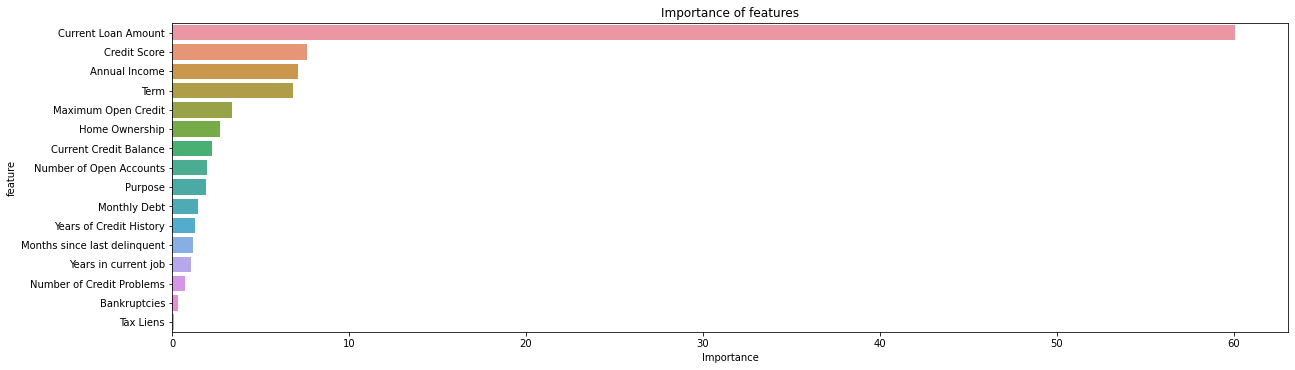

In [130]:
important_features_top = show_feature_importances(X_train.columns, cbc.feature_importances_, get_top=23)

In [131]:
pred_train = cbc.predict(X_train)
pred_test = cbc.predict(X_test)

pred_proba_test = cbc.predict_proba(X_test)
pred_proba_test[:5]

array([[0.6968225 , 0.3031775 ],
       [0.96805877, 0.03194123],
       [0.55334525, 0.44665475],
       [0.52352657, 0.47647343],
       [0.7006244 , 0.2993756 ]])

In [132]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

Accuracy на трейне 0.68700403278262
Accuracy на тесте 0.6926666666666667


In [ ]:
#Accuracy на трейне 0.7299089726918075
#Accuracy на тесте 0.6893333333333334

In [133]:
# Generate test predictions
X_test = pd.DataFrame(df_test , columns=features_all)

In [134]:
preds_test = cbc.predict(X_test)

In [135]:
preds_test

array([0, 1, 0, ..., 0, 0, 1])

In [136]:
 # Save predictions in format used for competition scoring
    
output = pd.DataFrame({'Id': np.arange(0,preds_test.shape[0]),
                       'Credit Default': preds_test.flatten()})
output.to_csv('submission.csv', index=False)

In [137]:
output.head(100)

,Id,Credit Default
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
95,95,1
96,96,0
97,97,0
98,98,0


In [138]:
output['Credit Default'].value_counts()

0    1776
1     724
Name: Credit Default, dtype: int64

## Подбор гиппепараметров

In [ ]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

In [ ]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':42,
     'cat_features':features_categ,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [ ]:
%%time

model_catb = cb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

## Снижение степени переобучения

In [ ]:
model_giper = cb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7, 
#                                 l2_leaf_reg=.5,
                                reg_lambda=0.5
                                )

#model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

#evaluate_preds(model, X_train, X_test, y_train, y_test)

In [ ]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [ ]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [ ]:
grid_search = model_giper.randomized_search(params,
                                      X_train,
                                      y_train,
                                      n_iter=50,
                                      cv=cv,
                                      stratified=True,
                                      plot=True,
                                      refit=True)